In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data_unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path,train=True,download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915,0.4823,0.4468),
                             (0.2470,0.2435,0.2616))
    ])
)

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path,train=False,download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915,0.4823,0.4468),
                             (0.2470,0.2435,0.2616))
    ])
)

Files already downloaded and verified


In [51]:
label_map = {0:0,2:1}
class_names = ['airplane','bird']
cifar2 = [(img,label_map[label]) for img,label in cifar10 if label in [0,2]]
cifar2_val = [(img,label_map[label]) for img,label in cifar10_val if label in [0,2]]

In [6]:
connected_model = nn.Sequential(nn.Linear(3072,1024),
                                nn.Tanh(),
                                nn.Linear(1024,512),
                                nn.Tanh(),
                                nn.Linear(512,128),
                                nn.Tanh(),
                                nn.Linear(128,2))

numel_list = [p.numel() for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list),numel_list
# connected_model.parameters()中包含所有可训练的参数张量，这些张量由模型的各个层的权重和偏置组成
# if p.requires_grad == True 用于过滤激活层nn.Tanh()
# 猜测：在.parameters中的权重分布 torch.tensor[[weight][bias][weight][bias]...]

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [7]:
first_model = nn.Sequential(nn.Linear(3072,512),
                            nn.Tanh(),
                            nn.Linear(512,2),
                            nn.LogSoftmax(dim=1))

numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list),numel_list

(1574402, [1572864, 512, 1024, 2])

In [8]:
conv =nn.Conv2d(3,16,kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [9]:
conv.weight.shape , conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [10]:
img,_ =  cifar2[0]
output = conv(img.unsqueeze(0)) #unsqueeze(0) 增加batch維度
img.shape, img.unsqueeze(0).shape,output.shape

(torch.Size([3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 16, 30, 30]))

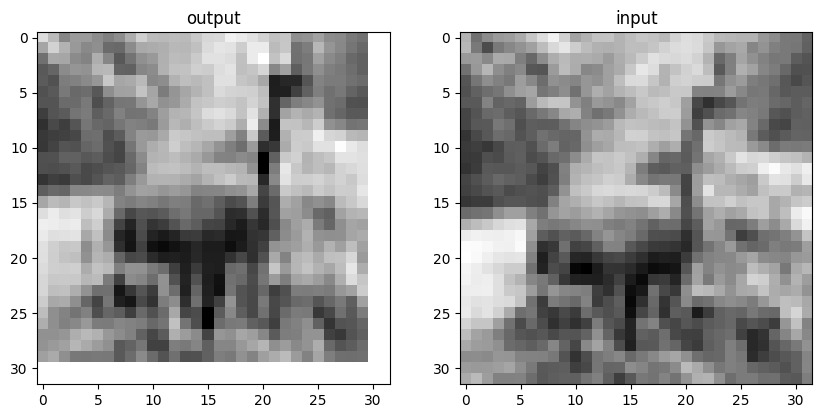

In [11]:
plt.figure(figsize=(10,4.8))
ax1 = plt.subplot(1,2,1)
plt.title('output')
plt.imshow(output[0,0].detach(),cmap='gray')
plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
plt.imshow(img.mean(0),cmap='gray')
plt.title('input')
plt.savefig('Ch8_F2_Pytorch.png')
plt.show()

In [12]:
conv = nn.Conv2d(3,16,kernel_size=(3,3),padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [13]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

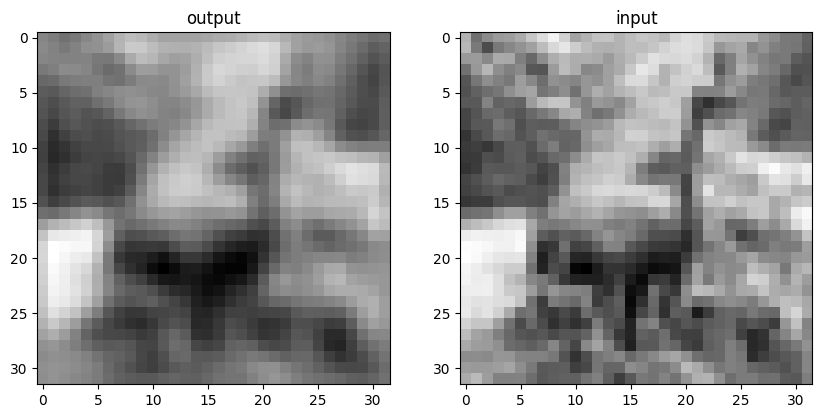

In [14]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10,4.8))
ax1 = plt.subplot(1,2,1)
plt.title('output')
plt.imshow(output[0][0].detach(),cmap='gray')
plt.subplot(1,2,2, sharex = ax1,sharey=ax1)
plt.imshow(img.mean(0),cmap='gray')
plt.title('input')
plt.savefig('Ch8_F2_Pytorch.png')
plt.show()

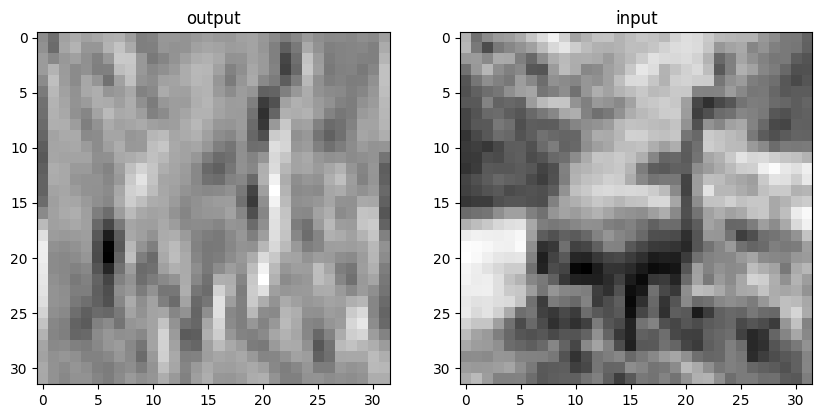

In [15]:
with torch.no_grad():
    conv.weight[:]= torch.tensor([[-1.0,0.0,1.0],
                                  [-1.0,0.0,1.0],
                                  [-1.0,0.0,1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.figure(figsize=(10,4.8))
ax1 = plt.subplot(1,2,1)
plt.title('output')
plt.imshow(output[0,0].detach(),cmap='gray')
plt.subplot(1,2,2,sharex=ax1,sharey=ax1)
plt.imshow(img.mean(0),cmap='gray') #img.mean(0) 沿着0维方向计算均值
plt.title('input')
plt.savefig('Ch8_F5_PyTorch.png')
plt.show()

In [16]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=(3,3),padding=1),#[1,16,32,32]
    nn.Tanh(),
    nn.MaxPool2d(2), #[1,16,16,16]
    nn.Conv2d(16,8,kernel_size=3,padding=1),#[1,8,16,16]
    nn.Tanh(),
    nn.MaxPool2d(2),#[1,8,8,8]
    #...这里需要一个层将上层四维参数打平成单维，用来衔接线性层
    nn.Linear(8*8*8,32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list),numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [18]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=(3,3),padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1=nn.Linear(8*8*8,32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)
        out = out.view(out.shape[0],-1)
        #-1表示自动推断该维度的大小 这里也可以写成 out=out.view(-1,8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out


In [20]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [21]:
model(img.unsqueeze(0))

tensor([[0.1664, 0.1527]], grad_fn=<AddmmBackward0>)

In [52]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=(3,3),padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=(3,3),padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [54]:
model(img.unsqueeze(0))

tensor([[0.1483, 0.1197]], grad_fn=<AddmmBackward0>)

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Training on device {device}')

Training on device cuda


In [56]:
import datetime

In [57]:
def training_loop_cpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        optimizer.zero_grad()
        for imgs_val,labels_val in val_loader:
            outputs = model(imgs_val)
            loss_batch_val = loss_fn(outputs,labels_val)
            loss_val += loss_batch_val.item()

        if epoch == 1 or (epoch+1) %10 == 0:
            print('{} Epoch{},Training loss {}, val loss{}'.format(datetime.datetime.now(),epoch,loss_train/len(train_loader),loss_val/(len(val_loader))))

In [58]:
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size=64,shuffle=False)

model=Net()

optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [59]:
training_loop_cpu(
    n_epochs=100,
    optimizer = optimizer,
    model = model,
    loss_fn=loss_fn,
    train_loader = train_loader,
    val_loader= val_loader
)

2023-06-26 10:01:39.936910 Epoch1,Training loss 0.48501660736503116, val loss0.4591739708557725
2023-06-26 10:01:50.408595 Epoch9,Training loss 0.327931498551065, val loss0.3399633765220642
2023-06-26 10:02:03.664721 Epoch19,Training loss 0.28334893713331527, val loss0.3011391689069569
2023-06-26 10:02:16.565171 Epoch29,Training loss 0.25653890178651567, val loss0.2948869480751455
2023-06-26 10:02:28.776795 Epoch39,Training loss 0.2352529077488146, val loss0.3123261774890125
2023-06-26 10:02:41.811721 Epoch49,Training loss 0.22193980572899435, val loss0.29439591243863106
2023-06-26 10:02:55.481630 Epoch59,Training loss 0.20741224179791798, val loss0.37345696752890944
2023-06-26 10:03:09.132811 Epoch69,Training loss 0.19400826125008286, val loss0.2753194672986865
2023-06-26 10:03:22.628031 Epoch79,Training loss 0.18241068675734434, val loss0.2773907692171633
2023-06-26 10:03:36.029236 Epoch89,Training loss 0.17067086421380376, val loss0.28629946522414684
2023-06-26 10:03:48.456704 Epoch

In [62]:
def training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(n_epochs):
        loss_train = 0.0
        loss_val = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        optimizer.zero_grad()
        for imgs_val,labels_val in val_loader:
            imgs_val = imgs_val.to(device=device)
            labels_val = labels_val.to(device=device)
            outputs = model(imgs_val)
            loss_batch_val = loss_fn(outputs,labels_val)
            loss_val += loss_batch_val.item()

        if epoch == 1 or (epoch+1) %10 == 0:
            print('{}  Epoch{},Training loss {}, val loss{}'.format(datetime.datetime.now(),epoch,loss_train/len(train_loader),loss_val/(len(val_loader))))

In [63]:
model = Net()
model =model.to(device = device)
optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [65]:
training_loop_gpu(
    n_epochs=100,
    optimizer = optimizer,
    model = model,
    loss_fn=loss_fn,
    train_loader = train_loader,
    val_loader= val_loader
)

2023-06-26 10:14:35.772697  Epoch1,Training loss 0.48252514365372384, val loss0.4548346996307373
2023-06-26 10:14:38.939090  Epoch9,Training loss 0.3238953174489319, val loss0.33637560484930873
2023-06-26 10:14:42.917543  Epoch19,Training loss 0.28999276582602485, val loss0.3150920467451215
2023-06-26 10:14:46.904108  Epoch29,Training loss 0.2655253161670296, val loss0.31056933430954814
2023-06-26 10:14:50.820369  Epoch39,Training loss 0.23997758210274825, val loss0.2801030962727964
2023-06-26 10:14:54.696023  Epoch49,Training loss 0.22323751563479186, val loss0.27688454277813435
2023-06-26 10:14:58.696031  Epoch59,Training loss 0.2068607658147812, val loss0.2629887054208666
2023-06-26 10:15:02.661957  Epoch69,Training loss 0.18934386071695644, val loss0.26374141103588045
2023-06-26 10:15:06.888052  Epoch79,Training loss 0.17425893840326626, val loss0.2585946130566299
2023-06-26 10:15:10.729650  Epoch89,Training loss 0.16098695030068136, val loss0.2635761769488454
2023-06-26 10:15:14.7

In [66]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=(3,3),padding=1)#图片输入为32*32*3
        self.conv2 = nn.Conv2d(32,16,kernel_size=(3,3),padding=1)
        self.fc1 = nn.Linear(8*8*16,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*16)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net().to(device = device)

In [68]:
model = Net().to(device=device)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size = 64,shuffle =True)
val_loader = torch.utils.data.DataLoader(cifar2,batch_size = 64,shuffle = False)

optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_gpu(
    n_epochs = 100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader= train_loader,
    val_loader= val_loader
)

2023-06-26 10:38:48.706795  Epoch1,Training loss 0.4656846857374641, val loss0.44647905610169575
2023-06-26 10:38:53.236008  Epoch9,Training loss 0.3135569624270603, val loss0.31157756459181474
2023-06-26 10:38:58.773244  Epoch19,Training loss 0.27522212627587045, val loss0.279881265702521
2023-06-26 10:39:04.287267  Epoch29,Training loss 0.24458810179286702, val loss0.26329027761699286
2023-06-26 10:39:09.754661  Epoch39,Training loss 0.2149194075613265, val loss0.32838575821963084
2023-06-26 10:39:15.232394  Epoch49,Training loss 0.1929901296830481, val loss0.18797393404184634
2023-06-26 10:39:20.711319  Epoch59,Training loss 0.17093188885101088, val loss0.17283006007694135
2023-06-26 10:39:26.255990  Epoch69,Training loss 0.15006340245247646, val loss0.16980539426017718
2023-06-26 10:39:31.744605  Epoch79,Training loss 0.12990277405282494, val loss0.1513624483138133
2023-06-26 10:39:37.388228  Epoch89,Training loss 0.11181662120162301, val loss0.1116582424540049
2023-06-26 10:39:42.

In [75]:
def training_loop_l2reg(n_epochs,optimizer,model,loss_fn,train_loader,val_loader):
    for epoch in range(1,n_epochs+1):
        loss_train =0.0
        loss_val = 0.0
        for imgs,labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss = loss_fn(output,labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss +l2_lambda*l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        optimizer.zero_grad()
        for imgs_val,labels_val in val_loader:
            imgs_val = imgs_val.to(device=device)
            labels_val = labels_val.to(device=device)
            outputs_val = model(imgs_val)
            loss_batch_val = loss_fn(outputs_val,labels_val)
            loss_val+=loss_batch_val.item()

        if epoch ==1 or epoch % 10 ==0:
            print('{}  Epoch:{}, Training Loss:{}, Val Loss:{}'.format(
                datetime.datetime.now(),epoch,
                loss_train/len(train_loader),
                loss_val/len(val_loader)
            ))

In [76]:
model = Net().to(device=device)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2,batch_size = 64,shuffle=False)
optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

2023-06-26 13:12:31.335688  Epoch:1, Training Loss:0.5913477388157207, Val Loss:0.48916058593494877
2023-06-26 13:12:37.835801  Epoch:10, Training Loss:0.34441316469459776, Val Loss:0.3139751574416069
2023-06-26 13:12:45.486841  Epoch:20, Training Loss:0.30468513232887173, Val Loss:0.2919388568610143
2023-06-26 13:12:52.714241  Epoch:30, Training Loss:0.2794537749260094, Val Loss:0.2582407786398177
2023-06-26 13:12:59.898666  Epoch:40, Training Loss:0.257699466624837, Val Loss:0.22307842860745777
2023-06-26 13:13:07.142139  Epoch:50, Training Loss:0.23420357727890562, Val Loss:0.2429659642326604
2023-06-26 13:13:14.443110  Epoch:60, Training Loss:0.2180615948738566, Val Loss:0.21067666181713152
2023-06-26 13:13:21.605093  Epoch:70, Training Loss:0.1995242051068385, Val Loss:0.17190559168055558
2023-06-26 13:13:28.718427  Epoch:80, Training Loss:0.18858839125390264, Val Loss:0.16590828920720488
2023-06-26 13:13:35.937452  Epoch:90, Training Loss:0.17424065743092518, Val Loss:0.142432158

In [77]:
model = Net().to(device=device)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size= 64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size = 64,shuffle=False)
# optimizer = optim.SGD(model.parameters(),lr=1e-2)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

2023-06-26 13:14:55.508633  Epoch:1, Training Loss:0.4288949313437104, Val Loss:0.3355512851552599
2023-06-26 13:15:03.227826  Epoch:10, Training Loss:0.2308111139543497, Val Loss:0.1517702518090321
2023-06-26 13:15:11.838301  Epoch:20, Training Loss:0.1585246867909553, Val Loss:0.0936319329034371
2023-06-26 13:15:20.428750  Epoch:30, Training Loss:0.135344514184317, Val Loss:0.047310657728060035
2023-06-26 13:15:28.887621  Epoch:40, Training Loss:0.12389581541346896, Val Loss:0.03300961354083032
2023-06-26 13:15:37.390772  Epoch:50, Training Loss:0.1176353469491005, Val Loss:0.04046628093880832
2023-06-26 13:15:46.164801  Epoch:60, Training Loss:0.11521156383737637, Val Loss:0.020974884008407402
2023-06-26 13:15:54.609470  Epoch:70, Training Loss:0.12557942311095585, Val Loss:0.05854076321480001
2023-06-26 13:16:03.302405  Epoch:80, Training Loss:0.10592553726616938, Val Loss:0.017863664206615677
2023-06-26 13:16:12.262968  Epoch:90, Training Loss:0.10297255042442091, Val Loss:0.01891

In [83]:
class NetDropout(nn.Module):
    def __init__(self,n_chans1=32):
        super().__init__()
        self.n_chans1= n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=(3,3),padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 =nn.Conv2d(n_chans1,n_chans1//2,kernel_size=(3,3),padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = self.conv2_dropout(out)
        out = out.view(-1,8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [94]:
model = NetDropout(n_chans1=32).to(device=device)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size= 64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size = 64,shuffle=False)
optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model = model,
    loss_fn= loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

2023-06-26 15:03:10.584030  Epoch:1, Training Loss:0.6120845166740904, Val Loss:0.5135655738413334
2023-06-26 15:03:16.447435  Epoch:10, Training Loss:0.40827892141737, Val Loss:0.38868282455950975
2023-06-26 15:03:22.690690  Epoch:20, Training Loss:0.3840621606369687, Val Loss:0.3604435487650335


KeyboardInterrupt: 

In [92]:
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.99


In [88]:
all_acc_dict["dropout"] = validate(model,train_loader=train_loader,val_loader=val_loader)

Accuracytrain: 0.90
Accuracyval: 0.90


NameError: name 'all_acc_dict' is not defined

In [89]:
class NetBatchNorm(nn.Module):
    def __init__(self,n_chan1=32):
        super().__init__()
        self.n_chans1 =n_chan1
        self.conv1 = nn.Conv2d(3,n_chan1,kernel_size=(3,3),padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chan1)
        self.conv2=nn.Conv2d(n_chan1,n_chan1//2,kernel_size=3,padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chan1//2)
        self.fc1 = nn.Linear(8*8*n_chan1//2,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out),2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out),2)
        out = out.view(-1,8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [95]:
model = NetBatchNorm(n_chan1=32).to(device=device)
optimizer = optim.SGD(model.parameters(),lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size= 64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size = 64,shuffle=False)
loss_fn= nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader
)

2023-06-26 15:03:36.622178  Epoch:1, Training Loss:0.5449434695350137, Val Loss:0.39524015970528126
2023-06-26 15:03:43.289051  Epoch:10, Training Loss:0.34611664114484364, Val Loss:0.293477981351316
2023-06-26 15:03:50.705650  Epoch:20, Training Loss:0.2974967035897978, Val Loss:0.2928524976596236
2023-06-26 15:03:57.918869  Epoch:30, Training Loss:0.2535837165489318, Val Loss:0.28891638526692986
2023-06-26 15:04:05.231487  Epoch:40, Training Loss:0.21597634303342006, Val Loss:0.30067515186965466
2023-06-26 15:04:12.478079  Epoch:50, Training Loss:0.19162158013149433, Val Loss:0.3661254523321986
2023-06-26 15:04:19.749858  Epoch:60, Training Loss:0.1691076123410729, Val Loss:0.334700187202543
2023-06-26 15:04:27.059617  Epoch:70, Training Loss:0.15350698470879512, Val Loss:0.6195342019200325
2023-06-26 15:04:34.455637  Epoch:80, Training Loss:0.13657809252951555, Val Loss:0.34356750594452024
2023-06-26 15:04:41.846794  Epoch:90, Training Loss:0.12340900610396817, Val Loss:0.3953356631

In [96]:
temp = validate(model,train_loader=train_loader,val_loader=val_loader)

Accuracy train: 0.95
Accuracy val: 0.86


In [115]:
class NetRes(nn.Module):
    def __init__(self,n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(n_chans1,n_chans1//2,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2,n_chans1//2,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = F.max_pool2d(torch.relu(self.conv2(out)),2)
        out1 = out
        out =F.max_pool2d(torch.relu(self.conv3(out))+ out1,2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [108]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [116]:
model = NetRes(n_chans1 = 32).to(device= device)
optimizer = optim.SGD(model.parameters(),lr= 1e-2)

loss_fn = nn.CrossEntropyLoss()
training_loop_l2reg(
    n_epochs= 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

2023-06-26 15:48:21.953299  Epoch:1, Training Loss:0.6619293955480976, Val Loss:0.5334691572934389
2023-06-26 15:48:28.656001  Epoch:10, Training Loss:0.3585868415179526, Val Loss:0.4347111517563462
2023-06-26 15:48:35.656361  Epoch:20, Training Loss:0.31749294318590954, Val Loss:0.28049354907125235
2023-06-26 15:48:42.516606  Epoch:30, Training Loss:0.28926404987930493, Val Loss:0.28737819707021117
2023-06-26 15:48:49.362407  Epoch:40, Training Loss:0.2633959049252188, Val Loss:0.2572847902774811
2023-06-26 15:48:56.138205  Epoch:50, Training Loss:0.24256140088579456, Val Loss:0.2669653566554189
2023-06-26 15:49:02.949365  Epoch:60, Training Loss:0.21999769183290993, Val Loss:0.273815696593374
2023-06-26 15:49:09.807501  Epoch:70, Training Loss:0.1981345122786844, Val Loss:0.24948967853561044
2023-06-26 15:49:16.865062  Epoch:80, Training Loss:0.19041296953608275, Val Loss:0.7140592038631439
2023-06-26 15:49:24.517461  Epoch:90, Training Loss:0.16498549149674216, Val Loss:0.2618490608

In [117]:
temp = validate(model,train_loader,val_loader)

Accuracy train: 0.97
Accuracy val: 0.91


In [125]:
class ResBlock(nn.Module):
    def __init__(self,n_chans):
        super(ResBlock,self).__init__()
        self.conv = nn.Conv2d(n_chans,n_chans,kernel_size=3,padding=1,bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        #权重参数的初始化
        torch.nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight,0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self,x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out +x

In [126]:
class NetResDeep(nn.Module):
    def __init__(self,n_chans1=32,n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks*[ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1,32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.resblocks(out)
        out = F.max_pool2d(out,2)
        out = out.view(-1,8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [127]:
model =NetResDeep(n_chans1=32,n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(),lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop_gpu(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)
temp = validate(model,train_loader,val_loader)

2023-06-26 17:58:16.367114  Epoch1,Training loss 0.47662949182425335, val loss0.4567755553871393
2023-06-26 17:59:42.092887  Epoch9,Training loss 0.32191791660656593, val loss0.4051929754205048
2023-06-26 18:01:30.189857  Epoch19,Training loss 0.25665861600713363, val loss0.3238971489481628
2023-06-26 18:03:18.135357  Epoch29,Training loss 0.19169970020461993, val loss0.6358259380795062
2023-06-26 18:05:06.133703  Epoch39,Training loss 0.1448209991405724, val loss0.46930999169126153
2023-06-26 18:06:54.062624  Epoch49,Training loss 0.10272498176118751, val loss1.1189011726528406
2023-06-26 18:08:43.015122  Epoch59,Training loss 0.08557656934117056, val loss0.47274179896339774
2023-06-26 18:10:31.328357  Epoch69,Training loss 0.08113301218380546, val loss0.6278000008314848
2023-06-26 18:12:19.443936  Epoch79,Training loss 0.048335591788629104, val loss2.3230073265731335
2023-06-26 18:14:07.876007  Epoch89,Training loss 0.07252925341937003, val loss0.6277065477333963
2023-06-26 18:15:56.